In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp

class LQRSolver:
    """
    Class for solving the Linear Quadratic Regulator (LQR) problem in 2 spatial
    and 2 control dimensions.
    
    This implements Exercise 1.1 with enhanced functionality for Monte Carlo simulation.
    """
    
    def __init__(self, H, M, C, D, R, sigma, T, time_grid):
        """
        Initialize the LQR solver with problem parameters.
        
        Parameters:
        -----------
        H : torch.Tensor, shape (2,2)
            State dynamics matrix
        M : torch.Tensor, shape (2,2)
            Control input matrix
        C : torch.Tensor, shape (2,2)
            State cost matrix (positive semi-definite)
        D : torch.Tensor, shape (2,2)
            Control cost matrix (positive definite)
        R : torch.Tensor, shape (2,2)
            Terminal state cost matrix (positive semi-definite)
        sigma : torch.Tensor, shape (2,d')
            Diffusion matrix
        T : float
            Terminal time
        time_grid : torch.Tensor or numpy.ndarray
            Time grid points for solving the Riccati ODE
        """
        # Save the problem parameters
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.sigma = sigma
        self.T = T
        
        # Convert time_grid to numpy array if it's a torch tensor
        if isinstance(time_grid, torch.Tensor):
            self.time_grid = time_grid.numpy()
        else:
            self.time_grid = time_grid
            
        # Compute D_inv to avoid repeated inversions
        self.D_inv = torch.inverse(D)
        
        # Solution of the Riccati ODE (will be filled later)
        self.S_solution = None
        
    def _riccati_ode(self, t, S_flat):
        """
        Define the Riccati ODE for use with scipy.integrate.solve_ivp.
        
        Parameters:
        -----------
        t : float
            Time
        S_flat : numpy.ndarray
            Flattened symmetric matrix S
            
        Returns:
        --------
        dS_flat : numpy.ndarray
            Flattened derivative of S
        """
        # Reshape flattened S into a 2x2 matrix
        S = S_flat.reshape(2, 2)
        
        # Convert numpy arrays to PyTorch tensors for easier matrix operations
        S_torch = torch.tensor(S, dtype=torch.float64)
        
        # Compute S*M*D^(-1)*M^T*S term
        SMD_inv_MT_S = S_torch @ self.M @ self.D_inv @ self.M.T @ S_torch
        
        # Compute H^T*S + S*H term
        HT_S_plus_S_H = self.H.T @ S_torch + S_torch @ self.H
        
        # Compute the derivative: S' = S*M*D^(-1)*M^T*S - H^T*S - S*H - C
        dS = SMD_inv_MT_S - HT_S_plus_S_H - self.C
        
        # Convert back to numpy and flatten for the ODE solver
        dS_np = dS.detach().numpy()
        dS_flat = dS_np.flatten()
        
        return dS_flat
    
    def solve_riccati_ode(self, rtol=1e-10, atol=1e-10):
        """
        Solve the Riccati ODE backward in time from t=T to t=0.
        
        Parameters:
        -----------
        rtol : float
            Relative tolerance for the ODE solver
        atol : float
            Absolute tolerance for the ODE solver
        """
        # Ensure time grid is in ascending order
        sorted_indices = np.argsort(self.time_grid)
        time_grid_sorted = self.time_grid[sorted_indices]
        
        # Terminal condition S(T) = R
        S_T_flat = self.R.detach().numpy().flatten()
        
        # Solve ODE backward in time
        solution = solve_ivp(
            fun=self._riccati_ode,
            t_span=(self.T, time_grid_sorted[0]),  # Integrate backward
            y0=S_T_flat,
            t_eval=np.flip(time_grid_sorted),  # Evaluate at these points
            method='RK45',
            rtol=rtol,
            atol=atol
        )
        
        # Reshape solution to get a time series of S matrices
        S_values = np.zeros((len(time_grid_sorted), 2, 2))
        for i in range(len(time_grid_sorted)):
            S_values[i] = solution.y[:, i].reshape(2, 2)
        
        # Re-order to match original time grid
        self.S_solution = S_values[np.argsort(np.flip(sorted_indices))]
        
        return self.S_solution
    
    def _get_S_at_time(self, t):
        """
        Get the matrix S at time t by finding the nearest time point in the grid.
        
        Parameters:
        -----------
        t : torch.Tensor or float
            Time point(s)
            
        Returns:
        --------
        S : torch.Tensor
            The matrix S evaluated at time t
        """
        if self.S_solution is None:
            self.solve_riccati_ode()
        
        # Convert t to numpy if it's a torch tensor
        if isinstance(t, torch.Tensor):
            t_np = t.detach().cpu().numpy()
        else:
            t_np = np.array(t)
        
        # Reshape to 1D if necessary
        if t_np.ndim == 0:
            t_np = np.array([t_np])
        
        # Find indices of nearest time points in the grid
        indices = np.array([np.argmin(np.abs(self.time_grid - ti)) for ti in t_np])
        
        # Get the corresponding S matrices
        S_values = torch.tensor([self.S_solution[idx] for idx in indices], dtype=torch.float32)
        
        return S_values
    
    def value_function(self, t, x):
        """
        Compute the value function v(t,x) for given time and state.
        
        Parameters:
        -----------
        t : torch.Tensor, shape (batch_size,) or float
            Time points
        x : torch.Tensor, shape (batch_size, 2) or (2,)
            State vectors
            
        Returns:
        --------
        v : torch.Tensor, shape (batch_size,)
            Value function evaluated at (t,x)
        """
        # Ensure x is 2D
        if x.dim() == 1:
            x = x.unsqueeze(0)
        
        # Ensure t is 1D
        if isinstance(t, (int, float)):
            t = torch.tensor([t])
        elif t.dim() == 0:
            t = t.unsqueeze(0)
        
        batch_size = x.shape[0]
        
        # If t is a scalar but x has many samples, expand t
        if len(t) == 1 and batch_size > 1:
            t = t.repeat(batch_size)
        
        # Get S matrices at the specified times
        S_t = self._get_S_at_time(t)
        
        v = torch.zeros(batch_size)
        
        # Compute x^T * S(t) * x for each (t,x) pair
        for i in range(batch_size):
            v[i] = torch.matmul(torch.matmul(x[i].unsqueeze(0), S_t[i]), x[i].unsqueeze(1)).squeeze()
        
        # Compute the trace term (constant part of value function)
        trace_term = torch.zeros_like(t, dtype=torch.float32)
        sigma_sigma_T = self.sigma @ self.sigma.T
        
        for i in range(batch_size):
            # Trace term depends on future times from t[i] to T
            # For simplicity, we'll use the trapezoidal rule for integration
            future_times_idx = self.time_grid >= t[i].item()
            if not any(future_times_idx):
                continue
                
            future_times = self.time_grid[future_times_idx]
            future_S = self.S_solution[future_times_idx]
            
            # Calculate trace(sigma*sigma^T*S) for all future times
            traces = np.array([np.trace(sigma_sigma_T.detach().numpy() @ S) for S in future_S])
            
            # Perform trapezoidal integration
            if len(future_times) > 1:
                dt = np.diff(future_times)
                integral = np.sum(0.5 * dt * (traces[:-1] + traces[1:]))
                trace_term[i] = torch.tensor(integral, dtype=torch.float32)
        
        # Final value function is x^T * S(t) * x + trace term
        return v + trace_term
    
    def optimal_control(self, t, x):
        """
        Compute the optimal Markov control a(t,x) for given time and state.
        
        Parameters:
        -----------
        t : torch.Tensor, shape (batch_size,) or float
            Time points
        x : torch.Tensor, shape (batch_size, 2) or (2,)
            State vectors
            
        Returns:
        --------
        a : torch.Tensor, shape (batch_size, 2)
            Optimal control actions
        """
        # Ensure x is 2D
        if x.dim() == 1:
            x = x.unsqueeze(0)
        
        # Ensure t is 1D
        if isinstance(t, (int, float)):
            t = torch.tensor([t])
        elif t.dim() == 0:
            t = t.unsqueeze(0)
        
        batch_size = x.shape[0]
        
        # If t is a scalar but x has many samples, expand t
        if len(t) == 1 and batch_size > 1:
            t = t.repeat(batch_size)
        
        # Get S matrices at the specified times
        S_t = self._get_S_at_time(t)
        
        a = torch.zeros((batch_size, 2))
        
        # Compute a(t,x) = -D^(-1) * M^T * S(t) * x for each (t,x) pair
        for i in range(batch_size):
            a[i] = -torch.matmul(self.D_inv, torch.matmul(self.M.T, torch.matmul(S_t[i], x[i])))
        
        return a
    
    def simulate_explicit_scheme(self, x0, t0, num_steps, mc_samples=1, seed=None):
        """
        Simulate the controlled SDE using an explicit Euler scheme.
        
        Parameters:
        -----------
        x0 : torch.Tensor, shape (2,)
            Initial state
        t0 : float
            Initial time
        num_steps : int
            Number of time steps for simulation
        mc_samples : int
            Number of Monte Carlo samples
        seed : int, optional
            Random seed for reproducibility
            
        Returns:
        --------
        X : torch.Tensor, shape (mc_samples, num_steps+1, 2)
            Simulated state trajectories
        cost : torch.Tensor, shape (mc_samples,)
            Cost values for each trajectory
        """
        # Set random seed if provided
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        # Time step
        tau = (self.T - t0) / num_steps
        
        # Time grid for simulation
        t_grid = torch.linspace(t0, self.T, num_steps + 1)
        
        # Initialize state trajectories
        X = torch.zeros((mc_samples, num_steps + 1, 2))
        X[:, 0, :] = x0.repeat(mc_samples, 1)
        
        # Initialize cost values
        cost = torch.zeros(mc_samples)
        
        # Generate Brownian motion increments
        dW = torch.randn(mc_samples, num_steps, self.sigma.shape[1]) * np.sqrt(tau)

        # Run simulation
        for n in range(num_steps):
            # Current time and state
            t_n = t_grid[n]
            X_n = X[:, n, :]
            
            # Compute optimal control
            a_n = self.optimal_control(t_n, X_n)
            
            # Update state using explicit scheme
            X[:, n+1, :] = X[:, n, :] + tau * (self.H @ X_n.T + self.M @ a_n.T).T + (self.sigma @ dW[:, n, :].T).T
            
            # Accumulate running cost
            running_cost = torch.zeros(mc_samples)
            for i in range(mc_samples):
                running_cost[i] = torch.matmul(torch.matmul(X[i, n, :].unsqueeze(0), self.C), X[i, n, :].unsqueeze(1)).squeeze()
                running_cost[i] += torch.matmul(torch.matmul(a_n[i, :].unsqueeze(0), self.D), a_n[i, :].unsqueeze(1)).squeeze()
            
            cost += running_cost * tau
        
        # Add terminal cost
        for i in range(mc_samples):
            cost[i] += torch.matmul(torch.matmul(X[i, -1, :].unsqueeze(0), self.R), X[i, -1, :].unsqueeze(1)).squeeze()
        
        return X, cost
    
    def simulate_implicit_scheme(self, x0, t0, num_steps, mc_samples=1, seed=None):
        """
        Simulate the controlled SDE using an implicit Euler scheme.
        
        Parameters:
        -----------
        x0 : torch.Tensor, shape (2,)
            Initial state
        t0 : float
            Initial time
        num_steps : int
            Number of time steps for simulation
        mc_samples : int
            Number of Monte Carlo samples
        seed : int, optional
            Random seed for reproducibility
            
        Returns:
        --------
        X : torch.Tensor, shape (mc_samples, num_steps+1, 2)
            Simulated state trajectories
        cost : torch.Tensor, shape (mc_samples,)
            Cost values for each trajectory
        """
        # Set random seed if provided
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        # Time step
        tau = (self.T - t0) / num_steps
        
        # Time grid for simulation
        t_grid = torch.linspace(t0, self.T, num_steps + 1)
        
        # Initialize state trajectories
        X = torch.zeros((mc_samples, num_steps + 1, 2))
        X[:, 0, :] = x0.repeat(mc_samples, 1)
        
        # Initialize cost values
        cost = torch.zeros(mc_samples)
        
        # Generate


import numpy as np
import torch
import matplotlib.pyplot as plt
import time

def test_time_step_convergence(lqr_solver, x0_values, t0=0.0, mc_samples=10000, seed=42):
    """
    Test convergence of the LQR solution with respect to the number of time steps.
    
    Parameters:
    -----------
    lqr_solver : LQRSolver
        The LQR solver object
    x0_values : list of torch.Tensor
        List of initial states to test
    t0 : float
        Initial time
    mc_samples : int
        Number of Monte Carlo samples
    seed : int
        Random seed for reproducibility
    
    Returns:
    --------
    step_sizes : list
        List of time step sizes used
    errors : dict
        Dictionary mapping each x0 to a list of errors
    """
    # Powers of 2 for time steps: 2, 4, 8, ..., 2048
    time_step_powers = range(1, 12)
    num_steps_values = [2**p for p in time_step_powers]
    step_sizes = [(lqr_solver.T - t0) / n for n in num_steps_values]
    
    # Dictionary to store errors for each x0
    errors = {tuple(x0.tolist()): [] for x0 in x0_values}
    
    # Compute exact values using the value function
    exact_values = {tuple(x0.tolist()): lqr_solver.value_function(t0, x0).item() for x0 in x0_values}
    
    print("Testing time step convergence...")
    total_steps = len(num_steps_values)
    
    # Measure convergence for each number of time steps
    for i, num_steps in enumerate(num_steps_values):
        print(f"  Progress: {i+1}/{total_steps} - Testing with {num_steps} time steps")
        start_time = time.time()
        
        # For each initial state
        for x0 in x0_values:
            # Simulate trajectories using the explicit scheme
            _, costs = lqr_solver.simulate_explicit_scheme(x0, t0, num_steps, mc_samples=mc_samples, seed=seed)
            
            # Calculate mean cost (Monte Carlo estimate of value function)
            mc_value = costs.mean().item()
            
            # Calculate absolute error
            error = abs(mc_value - exact_values[tuple(x0.tolist())])
            errors[tuple(x0.tolist())].append(error)
        
        elapsed_time = time.time() - start_time
        print(f"    Completed in {elapsed_time:.2f} seconds")
    
    return step_sizes, errors

def test_mc_samples_convergence(lqr_solver, x0_values, t0=0.0, num_steps=10000, seed=42):
    """
    Test convergence of the LQR solution with respect to the number of Monte Carlo samples.
    
    Parameters:
    -----------
    lqr_solver : LQRSolver
        The LQR solver object
    x0_values : list of torch.Tensor
        List of initial states to test
    t0 : float
        Initial time
    num_steps : int
        Number of time steps for simulation
    seed : int
        Random seed for reproducibility
    
    Returns:
    --------
    mc_samples_values : list
        List of Monte Carlo sample sizes used
    errors : dict
        Dictionary mapping each x0 to a list of errors
    """
    # Powers of 4 for MC samples: 2, 8, 32, 128, 512, 2048
    mc_powers = range(0, 6)
    mc_samples_values = [2 * 4**p for p in mc_powers]
    
    # Dictionary to store errors for each x0
    errors = {tuple(x0.tolist()): [] for x0 in x0_values}
    
    # Compute exact values using the value function
    exact_values = {tuple(x0.tolist()): lqr_solver.value_function(t0, x0).item() for x0 in x0_values}
    
    print("Testing MC samples convergence...")
    total_tests = len(mc_samples_values)
    
    # Measure convergence for each number of MC samples
    for i, mc_samples in enumerate(mc_samples_values):
        print(f"  Progress: {i+1}/{total_tests} - Testing with {mc_samples} Monte Carlo samples")
        start_time = time.time()
        
        # For each initial state
        for x0 in x0_values:
            # Simulate trajectories using the explicit scheme
            _, costs = lqr_solver.simulate_explicit_scheme(x0, t0, num_steps, mc_samples=mc_samples, seed=seed)
            
            # Calculate mean cost (Monte Carlo estimate of value function)
            mc_value = costs.mean().item()
            
            # Calculate absolute error
            error = abs(mc_value - exact_values[tuple(x0.tolist())])
            errors[tuple(x0.tolist())].append(error)
        
        elapsed_time = time.time() - start_time
        print(f"    Completed in {elapsed_time:.2f} seconds")
    
    return mc_samples_values, errors

def plot_convergence_results(x_values, errors_dict, x_label, title, expected_rate=None):
    """
    Plot convergence results on a log-log scale.
    
    Parameters:
    -----------
    x_values : list
        List of x-values (e.g., step sizes or MC sample sizes)
    errors_dict : dict
        Dictionary mapping each test case to a list of errors
    x_label : str
        Label for x-axis
    title : str
        Plot title
    expected_rate : float, optional
        Expected convergence rate for reference line
    """
    plt.figure(figsize=(10, 6))
    
    for key, errors in errors_dict.items():
        label = f"x0 = {key}"
        plt.loglog(x_values, errors, 'o-', label=label)
    
    # Add reference line if expected rate is provided
    if expected_rate is not None:
        # Get range for reference line
        x_min, x_max = min(x_values), max(x_values)
        y_ref_start = errors_dict[list(errors_dict.keys())[0]][0]  # Start at first error point
        
        # Generate reference line points
        x_ref = [x_min, x_max]
        y_ref = [y_ref_start, y_ref_start * (x_max/x_min)**expected_rate]
        
        plt.loglog(x_ref, y_ref, 'k--', label=f'Reference Rate: {expected_rate}')
    
    plt.xlabel(x_label)
    plt.ylabel('Absolute Error')
    plt.title(title)
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    
    return plt

def run_lqr_convergence_tests():
    """
    Main function to run all convergence tests for Exercise 1.2.
    """
    # Define problem parameters as given in Figure 1
    H = torch.tensor([[1.0, 1.0],
                      [0.0, 1.0]]) * 0.5
    M = torch.tensor([[1.0, 1.0],
                      [0.0, 1.0]])
    sigma = torch.eye(2) * 0.5
    C = torch.tensor([[1.0, 0.1],
                      [0.1, 1.0]]) * 1.0
    D = torch.tensor([[1.0, 0.1],
                      [0.1, 1.0]]) * 0.1
    R = torch.tensor([[1.0, 0.3],
                      [0.3, 1.0]]) * 10.0
    
    # Define problem parameters
    T = 0.5  # As specified in the exercise
    time_grid = np.linspace(0, T, 1000)  # Fine grid for accurate Riccati ODE solution
    
    # Create LQR solver
    lqr_solver = LQRSolver(H, M, C, D, R, sigma, T, time_grid)
    
    # Solve Riccati ODE with high accuracy
    print("Solving Riccati ODE with high accuracy...")
    lqr_solver.solve_riccati_ode(rtol=1e-12, atol=1e-12)
    print("Riccati ODE solution completed")
    
    # Define initial states to test
    x0_values = [
        torch.tensor([1.0, 1.0], dtype=torch.float32),
        torch.tensor([2.0, 2.0], dtype=torch.float32)
    ]
    
    # Starting time
    t0 = 0.0
    
    print("\n=== Running convergence tests for Exercise 1.2 ===")
    
    # Test 1: Convergence with respect to number of time steps
    print("\nTest 1: Convergence with respect to number of time steps")
    step_sizes, time_step_errors = test_time_step_convergence(
        lqr_solver, x0_values, t0=t0, mc_samples=10000, seed=42
    )
    
    # Test 2: Convergence with respect to number of Monte Carlo samples
    print("\nTest 2: Convergence with respect to number of Monte Carlo samples")
    mc_samples_values, mc_samples_errors = test_mc_samples_convergence(
        lqr_solver, x0_values, t0=t0, num_steps=10000, seed=42
    )
    
    # Plot results
    print("\nPlotting results...")
    
    # Plot time step convergence (expected rate: 1.0 for Euler scheme)
    time_step_plot = plot_convergence_results(
        step_sizes, 
        time_step_errors, 
        x_label="Time Step Size (Δt)",
        title="Convergence with respect to Time Step Size",
        expected_rate=1.0
    )
    time_step_plot.savefig("time_step_convergence.png")
    print("Time step convergence plot saved as 'time_step_convergence.png'")
    
    # Plot MC samples convergence (expected rate: -0.5 for Monte Carlo)
    mc_samples_plot = plot_convergence_results(
        mc_samples_values, 
        mc_samples_errors, 
        x_label="Number of Monte Carlo Samples",
        title="Convergence with respect to Monte Carlo Samples",
        expected_rate=-0.5
    )
    mc_samples_plot.savefig("mc_samples_convergence.png")
    print("MC samples convergence plot saved as 'mc_samples_convergence.png'")
    
    print("\n=== Convergence tests completed ===")
    
    # Print actual convergence rates
    print("\nEstimated convergence rates:")
    
    # For time step convergence
    for key in time_step_errors:
        # Use linear regression on log-log data to estimate rate
        x_log = np.log(step_sizes)
        y_log = np.log(time_step_errors[key])
        rate = np.polyfit(x_log, y_log, 1)[0]
        print(f"Time step convergence rate for x0={key}: {rate:.4f}")
        print(f"  Expected rate for Euler scheme: 1.0")
    
    # For MC samples convergence
    for key in mc_samples_errors:
        # Use linear regression on log-log data to estimate rate
        x_log = np.log(mc_samples_values)
        y_log = np.log(mc_samples_errors[key])
        rate = np.polyfit(x_log, y_log, 1)[0]
        print(f"MC samples convergence rate for x0={key}: {rate:.4f}")
        print(f"  Expected rate for Monte Carlo: -0.5")

    # Return results for further analysis if needed
    return {
        'time_step': {
            'sizes': step_sizes,
            'errors': time_step_errors
        },
        'mc_samples': {
            'sizes': mc_samples_values,
            'errors': mc_samples_errors
        }
    }

start_time = time.time()
run_lqr_convergence_tests()
total_time = time.time() - start_time
print(f"\nTotal execution time: {total_time:.2f} seconds")

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

def test_time_step_convergence(lqr_solver, x0_values, t0=0.0, mc_samples=10000, seed=42):
    """
    Test convergence of the LQR solution with respect to the number of time steps.
    
    Parameters:
    -----------
    lqr_solver : LQRSolver
        The LQR solver object
    x0_values : list of torch.Tensor
        List of initial states to test
    t0 : float
        Initial time
    mc_samples : int
        Number of Monte Carlo samples
    seed : int
        Random seed for reproducibility
    
    Returns:
    --------
    step_sizes : list
        List of time step sizes used
    errors : dict
        Dictionary mapping each x0 to a list of errors
    """
    # Powers of 2 for time steps: 2, 4, 8, ..., 2048
    time_step_powers = range(1, 12)
    num_steps_values = [2**p for p in time_step_powers]
    step_sizes = [(lqr_solver.T - t0) / n for n in num_steps_values]
    
    # Dictionary to store errors for each x0
    errors = {tuple(x0.tolist()): [] for x0 in x0_values}
    
    # Compute exact values using the value function
    exact_values = {tuple(x0.tolist()): lqr_solver.value_function(t0, x0).item() for x0 in x0_values}
    
    print("Testing time step convergence...")
    total_steps = len(num_steps_values)
    
    # Measure convergence for each number of time steps
    for i, num_steps in enumerate(num_steps_values):
        print(f"  Progress: {i+1}/{total_steps} - Testing with {num_steps} time steps")
        start_time = time.time()
        
        # For each initial state
        for x0 in x0_values:
            # Simulate trajectories using the explicit scheme
            _, costs = lqr_solver.simulate_explicit_scheme(x0, t0, num_steps, mc_samples=mc_samples, seed=seed)
            
            # Calculate mean cost (Monte Carlo estimate of value function)
            mc_value = costs.mean().item()
            
            # Calculate absolute error
            error = abs(mc_value - exact_values[tuple(x0.tolist())])
            errors[tuple(x0.tolist())].append(error)
        
        elapsed_time = time.time() - start_time
        print(f"    Completed in {elapsed_time:.2f} seconds")
    
    return step_sizes, errors

def test_mc_samples_convergence(lqr_solver, x0_values, t0=0.0, num_steps=10000, seed=42):
    """
    Test convergence of the LQR solution with respect to the number of Monte Carlo samples.
    
    Parameters:
    -----------
    lqr_solver : LQRSolver
        The LQR solver object
    x0_values : list of torch.Tensor
        List of initial states to test
    t0 : float
        Initial time
    num_steps : int
        Number of time steps for simulation
    seed : int
        Random seed for reproducibility
    
    Returns:
    --------
    mc_samples_values : list
        List of Monte Carlo sample sizes used
    errors : dict
        Dictionary mapping each x0 to a list of errors
    """
    # Powers of 4 for MC samples: 2, 8, 32, 128, 512, 2048
    mc_powers = range(0, 6)
    mc_samples_values = [2 * 4**p for p in mc_powers]
    
    # Dictionary to store errors for each x0
    errors = {tuple(x0.tolist()): [] for x0 in x0_values}
    
    # Compute exact values using the value function
    exact_values = {tuple(x0.tolist()): lqr_solver.value_function(t0, x0).item() for x0 in x0_values}
    
    print("Testing MC samples convergence...")
    total_tests = len(mc_samples_values)
    
    # Measure convergence for each number of MC samples
    for i, mc_samples in enumerate(mc_samples_values):
        print(f"  Progress: {i+1}/{total_tests} - Testing with {mc_samples} Monte Carlo samples")
        start_time = time.time()
        
        # For each initial state
        for x0 in x0_values:
            # Simulate trajectories using the explicit scheme
            _, costs = lqr_solver.simulate_explicit_scheme(x0, t0, num_steps, mc_samples=mc_samples, seed=seed)
            
            # Calculate mean cost (Monte Carlo estimate of value function)
            mc_value = costs.mean().item()
            
            # Calculate absolute error
            error = abs(mc_value - exact_values[tuple(x0.tolist())])
            errors[tuple(x0.tolist())].append(error)
        
        elapsed_time = time.time() - start_time
        print(f"    Completed in {elapsed_time:.2f} seconds")
    
    return mc_samples_values, errors

def plot_convergence_results(x_values, errors_dict, x_label, title, expected_rate=None):
    """
    Plot convergence results on a log-log scale.
    
    Parameters:
    -----------
    x_values : list
        List of x-values (e.g., step sizes or MC sample sizes)
    errors_dict : dict
        Dictionary mapping each test case to a list of errors
    x_label : str
        Label for x-axis
    title : str
        Plot title
    expected_rate : float, optional
        Expected convergence rate for reference line
    """
    plt.figure(figsize=(10, 6))
    
    for key, errors in errors_dict.items():
        label = f"x0 = {key}"
        plt.loglog(x_values, errors, 'o-', label=label)
    
    # Add reference line if expected rate is provided
    if expected_rate is not None:
        # Get range for reference line
        x_min, x_max = min(x_values), max(x_values)
        y_ref_start = errors_dict[list(errors_dict.keys())[0]][0]  # Start at first error point
        
        # Generate reference line points
        x_ref = [x_min, x_max]
        y_ref = [y_ref_start, y_ref_start * (x_max/x_min)**expected_rate]
        
        plt.loglog(x_ref, y_ref, 'k--', label=f'Reference Rate: {expected_rate}')
    
    plt.xlabel(x_label)
    plt.ylabel('Absolute Error')
    plt.title(title)
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    
    return plt

def run_lqr_convergence_tests():
    """
    Main function to run all convergence tests for Exercise 1.2.
    """
    # Define problem parameters as given in Figure 1
    H = torch.tensor([[1.0, 1.0],
                      [0.0, 1.0]]) * 0.5
    M = torch.tensor([[1.0, 1.0],
                      [0.0, 1.0]])
    sigma = torch.eye(2) * 0.5
    C = torch.tensor([[1.0, 0.1],
                      [0.1, 1.0]]) * 1.0
    D = torch.tensor([[1.0, 0.1],
                      [0.1, 1.0]]) * 0.1
    R = torch.tensor([[1.0, 0.3],
                      [0.3, 1.0]]) * 10.0
    
    # Define problem parameters
    T = 0.5  # As specified in the exercise
    time_grid = np.linspace(0, T, 1000)  # Fine grid for accurate Riccati ODE solution
    
    # Create LQR solver
    lqr_solver = LQRSolver(H, M, C, D, R, sigma, T, time_grid)
    
    # Solve Riccati ODE with high accuracy
    print("Solving Riccati ODE with high accuracy...")
    lqr_solver.solve_riccati_ode(rtol=1e-12, atol=1e-12)
    print("Riccati ODE solution completed")
    
    # Define initial states to test
    x0_values = [
        torch.tensor([1.0, 1.0], dtype=torch.float32),
        torch.tensor([2.0, 2.0], dtype=torch.float32)
    ]
    
    # Starting time
    t0 = 0.0
    
    print("\n=== Running convergence tests for Exercise 1.2 ===")
    
    # Test 1: Convergence with respect to number of time steps
    print("\nTest 1: Convergence with respect to number of time steps")
    step_sizes, time_step_errors = test_time_step_convergence(
        lqr_solver, x0_values, t0=t0, mc_samples=10000, seed=42
    )
    
    # Test 2: Convergence with respect to number of Monte Carlo samples
    print("\nTest 2: Convergence with respect to number of Monte Carlo samples")
    mc_samples_values, mc_samples_errors = test_mc_samples_convergence(
        lqr_solver, x0_values, t0=t0, num_steps=10000, seed=42
    )
    
    # Plot results
    print("\nPlotting results...")
    
    # Plot time step convergence (expected rate: 1.0 for Euler scheme)
    time_step_plot = plot_convergence_results(
        step_sizes, 
        time_step_errors, 
        x_label="Time Step Size (Δt)",
        title="Convergence with respect to Time Step Size",
        expected_rate=1.0
    )
    time_step_plot.savefig("time_step_convergence.png")
    print("Time step convergence plot saved as 'time_step_convergence.png'")
    
    # Plot MC samples convergence (expected rate: -0.5 for Monte Carlo)
    mc_samples_plot = plot_convergence_results(
        mc_samples_values, 
        mc_samples_errors, 
        x_label="Number of Monte Carlo Samples",
        title="Convergence with respect to Monte Carlo Samples",
        expected_rate=-0.5
    )
    mc_samples_plot.savefig("mc_samples_convergence.png")
    print("MC samples convergence plot saved as 'mc_samples_convergence.png'")
    
    print("\n=== Convergence tests completed ===")
    
    # Print actual convergence rates
    print("\nEstimated convergence rates:")
    
    # For time step convergence
    for key in time_step_errors:
        # Use linear regression on log-log data to estimate rate
        x_log = np.log(step_sizes)
        y_log = np.log(time_step_errors[key])
        rate = np.polyfit(x_log, y_log, 1)[0]
        print(f"Time step convergence rate for x0={key}: {rate:.4f}")
        print(f"  Expected rate for Euler scheme: 1.0")
    
    # For MC samples convergence
    for key in mc_samples_errors:
        # Use linear regression on log-log data to estimate rate
        x_log = np.log(mc_samples_values)
        y_log = np.log(mc_samples_errors[key])
        rate = np.polyfit(x_log, y_log, 1)[0]
        print(f"MC samples convergence rate for x0={key}: {rate:.4f}")
        print(f"  Expected rate for Monte Carlo: -0.5")

    # Return results for further analysis if needed
    return {
        'time_step': {
            'sizes': step_sizes,
            'errors': time_step_errors
        },
        'mc_samples': {
            'sizes': mc_samples_values,
            'errors': mc_samples_errors
        }
    }

start_time = time.time()
run_lqr_convergence_tests()
total_time = time.time() - start_time
print(f"\nTotal execution time: {total_time:.2f} seconds")

Solving Riccati ODE with high accuracy...


RuntimeError: expected m1 and m2 to have the same dtype, but got: double != float

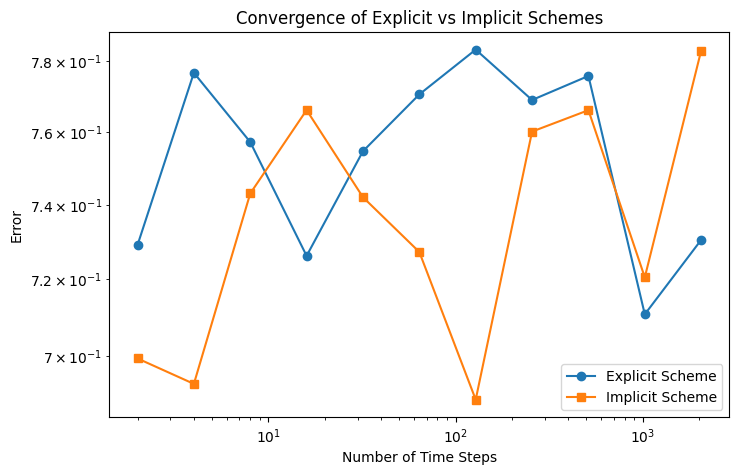

In [5]:
import numpy as np
import torch
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

class LQR:
    def __init__(self, H, M, sigma, C, D, R, T, time_grid):
        self.H = H.numpy()
        self.M = M.numpy()
        self.sigma = sigma
        self.C = C.numpy()
        self.D = D.numpy()
        self.R = R.numpy()
        self.T = T
        self.time_grid = time_grid.numpy()
        self.S = self.solve_riccati()
    
    def riccati_ode(self, t, S_flat):
        """ Computes dS/dt for the Riccati ODE using NumPy arrays. """
        S = S_flat.reshape(2, 2)  # Reshape flattened S
        D_inv = np.linalg.inv(self.D)  # Compute inverse using NumPy
        dSdt = S @ self.M @ D_inv @ self.M.T @ S - self.H.T @ S - S @ self.H - self.C
        return dSdt.flatten()
    
    def solve_riccati(self):
        """ Solves the Riccati equation backwards in time. """
        sol = solve_ivp(
            self.riccati_ode,
            [self.T, 0],  # Integrate backward from T to 0
            self.R.flatten(),  # Ensure NumPy array
            t_eval=self.time_grid[::-1],  # Reverse time grid for backward integration
            method='RK45',
        )
        return {t: torch.tensor(S.reshape(2, 2), dtype=torch.float32) for t, S in zip(sol.t[::-1], sol.y.T[::-1])}  # Reverse solution
    
    def value_function(self, t, x):
        """ Computes v(t, x) = x^T S(t) x + integral term. """
        S_t = self.S[min(self.time_grid, key=lambda tn: abs(tn - t))]  # Closest grid point
        integral_term = sum(torch.trace(self.sigma @ self.sigma.T @ self.S[tau]) * (self.time_grid[1] - self.time_grid[0]) for tau in self.time_grid if tau >= t)
        return x.T @ S_t @ x + integral_term
    
    def optimal_control(self, t, x):
        """ Computes a(t, x) = -D^(-1) M^T S(t) x. """
        S_t = self.S[min(self.time_grid, key=lambda tn: abs(tn - t))]
        return -torch.linalg.inv(torch.tensor(self.D)) @ torch.tensor(self.M.T) @ S_t @ x
    
    def explicit_scheme(self, x0, N):
        dt = self.T / N
        x = x0.clone()
        for _ in range(N):
            a = self.optimal_control(0, x)
            x += (torch.tensor(self.H) @ x + torch.tensor(self.M) @ a) * dt + self.sigma @ torch.randn(2, 1) * np.sqrt(dt)
        return x
    
    def implicit_scheme(self, x0, N):
        dt = self.T / N
        x = x0.clone()
        I = torch.eye(2)
        for _ in range(N):
            a = self.optimal_control(0, x)
            x = torch.linalg.solve(I - dt * torch.tensor(self.H), x + dt * torch.tensor(self.M) @ a + self.sigma @ torch.randn(2, 1) * np.sqrt(dt))
        return x

# Test Cases for Exercise 1.2
def test_lqr_monte_carlo():
    H = torch.tensor([[0.5, 0.5], [0.0, 0.5]])
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]])
    sigma = torch.eye(2) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]])
    D = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 0.1
    R = torch.tensor([[1.0, 0.3], [0.3, 1.0]]) * 10.0
    T = 0.5
    time_grid = torch.linspace(0, T, 1000)
    lqr = LQR(H, M, sigma, C, D, R, T, time_grid)
    
    x0 = torch.tensor([[1.0], [1.0]])
    N_values = [2**i for i in range(1, 12)]
    explicit_errors = []
    implicit_errors = []
    
    for N in N_values:
        x_explicit = lqr.explicit_scheme(x0, N)
        x_implicit = lqr.implicit_scheme(x0, N)
        true_value = lqr.value_function(0, x0)
        explicit_errors.append(torch.norm(true_value - x_explicit.T @ lqr.S[0] @ x_explicit).item())
        implicit_errors.append(torch.norm(true_value - x_implicit.T @ lqr.S[0] @ x_implicit).item())
    
    plt.figure(figsize=(8, 5))
    plt.loglog(N_values, explicit_errors, '-o', label='Explicit Scheme')
    plt.loglog(N_values, implicit_errors, '-s', label='Implicit Scheme')
    plt.xlabel('Number of Time Steps')
    plt.ylabel('Error')
    plt.title('Convergence of Explicit vs Implicit Schemes')
    plt.legend()
    plt.show()

test_lqr_monte_carlo()

In [ ]:
import numpy as np
import torch
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

class LQR:
    def __init__(self, H, M, sigma, C, D, R, T, time_grid):
        """Initialize the LQR solver with problem parameters."""
        # Store parameters as NumPy arrays for solve_ivp compatibility
        self.H = H.numpy() if isinstance(H, torch.Tensor) else H
        self.M = M.numpy() if isinstance(M, torch.Tensor) else M
        self.sigma = sigma
        self.C = C.numpy() if isinstance(C, torch.Tensor) else C
        self.D = D.numpy() if isinstance(D, torch.Tensor) else D
        self.R = R.numpy() if isinstance(R, torch.Tensor) else R
        self.T = T
        self.time_grid = time_grid.numpy() if isinstance(time_grid, torch.Tensor) else time_grid
        
        # Store torch versions for later use
        self.H_torch = H if isinstance(H, torch.Tensor) else torch.tensor(H, dtype=torch.float32)
        self.M_torch = M if isinstance(M, torch.Tensor) else torch.tensor(M, dtype=torch.float32)
        self.D_torch = D if isinstance(D, torch.Tensor) else torch.tensor(D, dtype=torch.float32)
        
        # Solve Riccati equation
        self.S = self.solve_riccati()
        
        # Precompute integral term for efficiency
        self.integral_terms = self._precompute_integral_terms()
    
    def riccati_ode(self, t, S_flat):
        """Computes dS/dt for the Riccati ODE."""
        S = S_flat.reshape(2, 2)
        D_inv = np.linalg.inv(self.D)
        dSdt = (S @ self.M @ D_inv @ self.M.T @ S - 
                self.H.T @ S - S @ self.H - self.C)
        return dSdt.flatten()
    
    def solve_riccati(self):
        """Solves the Riccati equation backwards in time."""
        sol = solve_ivp(
            self.riccati_ode,
            [self.T, 0],  # Integrate backward from T to 0
            self.R.flatten(),
            t_eval=self.time_grid[::-1],  # Reverse time grid for backward integration
            method='RK45',
            rtol=1e-12,
            atol=1e-12
        )
        
        # Create dictionary mapping time points to S matrices
        S_dict = {}
        for t, S_flat in zip(sol.t[::-1], sol.y.T[::-1]):
            S_dict[t] = torch.tensor(S_flat.reshape(2, 2), dtype=torch.float32)
        
        return S_dict
    
    def _precompute_integral_terms(self):
        """Precomputes integral terms for value function for efficiency."""
        dt = self.time_grid[1] - self.time_grid[0]
        integral_terms = {}
        
        # Convert sigma to torch tensor if needed
        sigma_torch = self.sigma if isinstance(self.sigma, torch.Tensor) else torch.tensor(self.sigma, dtype=torch.float32)
        sigma_sigma_T = sigma_torch @ sigma_torch.T
        
        # Compute integral terms for each time point
        for t_idx, t in enumerate(self.time_grid):
            integral_term = 0.0
            for tau_idx in range(t_idx, len(self.time_grid)):
                tau = self.time_grid[tau_idx]
                S_tau = self.S[tau]
                integral_term += torch.trace(sigma_sigma_T @ S_tau).item() * dt
            
            integral_terms[t] = integral_term
        
        return integral_terms
    
    def get_nearest_time(self, t):
        """Gets the nearest time point in the time grid."""
        return min(self.time_grid, key=lambda tn: abs(tn - t))
    
    def value_function(self, t, x):
        """Computes the value function v(t, x) = x^T S(t) x + integral term."""
        t_val = t.item() if isinstance(t, torch.Tensor) else t
        nearest_t = self.get_nearest_time(t_val)
        
        # Get S matrix for nearest time point
        S_t = self.S[nearest_t]
        
        # Use precomputed integral term
        integral_term = self.integral_terms[nearest_t]
        
        # Reshape x if needed
        if len(x.shape) == 1:
            x = x.reshape(-1, 1)
        
        return x.T @ S_t @ x + integral_term
    
    def optimal_control(self, t, x):
        """Computes the optimal control a(t, x) = -D^(-1) M^T S(t) x."""
        t_val = t.item() if isinstance(t, torch.Tensor) else t
        nearest_t = self.get_nearest_time(t_val)
        
        # Get S matrix for nearest time point
        S_t = self.S[nearest_t]
        
        # Compute D^(-1) M^T S(t) x
        D_inv = torch.linalg.inv(self.D_torch)
        
        # Reshape x if needed
        if len(x.shape) == 1:
            x = x.reshape(-1, 1)
        
        return -D_inv @ self.M_torch.T @ S_t @ x
    
    def explicit_scheme(self, x0, N):
        """Simulates a trajectory using the explicit scheme."""
        dt = self.T / N
        x = x0.clone()
        
        if len(x.shape) == 1:
            x = x.reshape(-1, 1)
        
        for _ in range(N):
            a = self.optimal_control(0, x)
            x = x + (self.H_torch @ x + self.M_torch @ a) * dt + self.sigma @ torch.randn(2, 1) * np.sqrt(dt)
        
        return x
    
    def implicit_scheme(self, x0, N):
        """Simulates a trajectory using the implicit scheme."""
        dt = self.T / N
        x = x0.clone()
        
        if len(x.shape) == 1:
            x = x.reshape(-1, 1)
        
        I = torch.eye(2)
        
        for _ in range(N):
            a = self.optimal_control(0, x)
            b = x + dt * self.M_torch @ a + self.sigma @ torch.randn(2, 1) * np.sqrt(dt)
            x = torch.linalg.solve(I - dt * self.H_torch, b)
        
        return x
    
    def monte_carlo_time_steps(self, x0, schemes, N_values, num_samples, seed=None):
        """Analyzes convergence with respect to time steps."""
        if seed is not None:
            torch.manual_seed(seed)
        
        # Compute true value
        true_value = self.value_function(0, x0)
        errors = {scheme: [] for scheme in schemes}
        
        for N in N_values:
            for scheme in schemes:
                total_error = 0.0
                for _ in range(num_samples):
                    if scheme == 'explicit':
                        x_final = self.explicit_scheme(x0, N)
                    else:  # implicit
                        x_final = self.implicit_scheme(x0, N)
                        
                    # Compute final value and error
                    final_value = x_final.T @ self.S[self.T] @ x_final
                    total_error += torch.abs(true_value - final_value).item()
                
                errors[scheme].append(total_error / num_samples)
        
        return errors, true_value
    
    def monte_carlo_samples(self, x0, schemes, N, sample_values, seed=None):
        """Analyzes convergence with respect to number of samples."""
        if seed is not None:
            torch.manual_seed(seed)
        
        true_value = self.value_function(0, x0)
        errors = {scheme: [] for scheme in schemes}
        
        # Pre-generate full simulation data for each scheme
        sim_results = {scheme: [] for scheme in schemes}
        
        # Maximum number of samples needed
        max_samples = max(sample_values)
        
        # Generate simulation results for all needed samples
        for scheme in schemes:
            for _ in range(max_samples):
                if scheme == 'explicit':
                    x_final = self.explicit_scheme(x0, N)
                else:  # implicit
                    x_final = self.implicit_scheme(x0, N)
                    
                # Compute final value
                final_value = x_final.T @ self.S[self.T] @ x_final
                error = torch.abs(true_value - final_value).item()
                sim_results[scheme].append(error)
        
        # Calculate errors for different sample sizes
        for scheme in schemes:
            for num_samples in sample_values:
                errors[scheme].append(sum(sim_results[scheme][:num_samples]) / num_samples)
        
        return errors, true_value

def test_lqr_monte_carlo():
    """Test case for Exercise 1.2"""
    # Define problem parameters
    H = torch.tensor([[0.5, 0.5], [0.0, 0.5]])
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]])
    sigma = torch.eye(2) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]])
    D = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 0.1
    R = torch.tensor([[1.0, 0.3], [0.3, 1.0]]) * 10.0
    T = 0.5
    time_grid = torch.linspace(0, T, 1000)
    
    # Create LQR solver
    lqr = LQR(H, M, sigma, C, D, R, T, time_grid)
    
    # Test states
    x0 = torch.tensor([[1.0], [1.0]])
    x1 = torch.tensor([[2.0], [2.0]])
    
    # Test time step convergence
    schemes = ['explicit', 'implicit']
    N_values = [2**i for i in range(1, 12)]
    num_samples = 10000
    
    errors, true_value = lqr.monte_carlo_time_steps(x0, schemes, N_values, num_samples, seed=42)
    
    # Plot time step convergence
    plt.figure(figsize=(10, 6))
    for scheme in schemes:
        plt.loglog(N_values, errors[scheme], '-o', label=f'{scheme.capitalize()} Scheme')
    
    # Add reference slopes
    x_ref = np.array([N_values[0], N_values[-1]])
    y_ref_half = true_value.item() * x_ref[0]**0.5 / x_ref**0.5
    y_ref_one = true_value.item() * x_ref[0] / x_ref
    
    plt.loglog(x_ref, y_ref_half, '--', label='O(N^(-1/2))')
    # plt.loglog(x_ref, y_ref_one, '-.', label='O(N^(-1))')
    
    plt.xlabel('Number of Time Steps (N)')
    plt.ylabel('Error')
    plt.title('Convergence of Schemes with Respect to Time Steps')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()
    
    # Test sample size convergence
    N = 10000  # Fixed large number of time steps
    sample_values = [2 * 4**i for i in range(6)]
    
    errors, true_value = lqr.monte_carlo_samples(x0, schemes, N, sample_values, seed=42)
    
    # Plot sample size convergence
    plt.figure(figsize=(10, 6))
    for scheme in schemes:
        plt.loglog(sample_values, errors[scheme], '-o', label=f'{scheme.capitalize()} Scheme')
    
    # Add reference slope
    x_ref = np.array([sample_values[0], sample_values[-1]])
    y_ref = true_value.item() * np.sqrt(x_ref[0]) / np.sqrt(x_ref)
    
    plt.loglog(x_ref, y_ref, '--', label='O(M^(-1/2))')
    
    plt.xlabel('Number of Monte Carlo Samples (M)')
    plt.ylabel('Error')
    plt.title('Convergence of Schemes with Respect to Sample Size')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()

test_lqr_monte_carlo()

In [ ]:
import numpy as np
import torch
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

class SoftLQR(LQR):
    def __init__(self, H, M, sigma, C, D, R, T, time_grid, tau, gamma):
        """Initialize the Soft LQR solver with problem parameters."""
        # Call parent class initializer
        super().__init__(H, M, sigma, C, D, R, T, time_grid)
        
        # Store regularization parameters
        self.tau = tau
        self.gamma = gamma
        
        # Store extended torch versions
        self.tau_torch = tau if isinstance(tau, torch.Tensor) else torch.tensor(tau, dtype=torch.float32)
        self.gamma_torch = gamma if isinstance(gamma, torch.Tensor) else torch.tensor(gamma, dtype=torch.float32)
        
        # Compute adjusted D matrix for soft LQR (D_tilde)
        self.D_tilde_torch = self.D_torch + self.tau_torch * torch.eye(self.D_torch.shape[0])
        self.D_tilde = self.D_tilde_torch.numpy()
        
        # Solve adjusted Riccati equation for soft LQR
        self.S = self.solve_riccati()
        
        # Precompute integral terms
        self.integral_terms = self._precompute_integral_terms()
    
    def riccati_ode(self, t, S_flat):
        """Computes dS/dt for the soft LQR Riccati ODE."""
        S = S_flat.reshape(2, 2)
        D_tilde_inv = np.linalg.inv(self.D_tilde)
        dSdt = (S @ self.M @ D_tilde_inv @ self.M.T @ S - 
                self.H.T @ S - S @ self.H - self.C)
        return dSdt.flatten()
    
    def optimal_policy_distribution(self, t, x):
        """
        Returns the parameters of the Gaussian policy distribution for optimal control.
        
        Parameters:
        t (float or torch.Tensor): Time value
        x (torch.Tensor): State vector
        
        Returns:
        tuple: (mean, covariance) of the Gaussian policy distribution
        """
        t_val = t.item() if isinstance(t, torch.Tensor) else t
        nearest_t = self.get_nearest_time(t_val)
        
        # Get S matrix for nearest time point
        S_t = self.S[nearest_t]
        
        # Reshape x if needed
        if len(x.shape) == 1:
            x = x.reshape(-1, 1)
        
        # Compute mean of the policy distribution
        D_tilde_inv = torch.linalg.inv(self.D_tilde_torch)
        mean = -D_tilde_inv @ self.M_torch.T @ S_t @ x
        
        # Compute covariance of the policy distribution
        covariance = self.tau_torch * D_tilde_inv
        
        return mean, covariance
    
    def sample_optimal_control(self, t, x):
        """
        Samples an action from the optimal policy distribution.
        
        Parameters:
        t (float or torch.Tensor): Time value
        x (torch.Tensor): State vector
        
        Returns:
        torch.Tensor: Sampled control action
        """
        mean, covariance = self.optimal_policy_distribution(t, x)
        
        # Create multivariate normal distribution
        dist = torch.distributions.MultivariateNormal(mean.squeeze(), covariance)
        
        # Sample action
        action = dist.sample()
        
        # Reshape to match expected format
        return action.reshape(-1, 1)
    
    def value_function(self, t, x):
        """
        Computes the value function for the soft LQR problem.
        
        This includes the standard LQR value function plus a regularization term.
        """
        # Get the standard LQR value function
        standard_value = super().value_function(t, x)
        
        # Compute the entropic regularization term
        # In the soft LQR case, there's an additional term related to tau and gamma
        t_val = t.item() if isinstance(t, torch.Tensor) else t
        nearest_t = self.get_nearest_time(t_val)
        time_to_go = self.T - nearest_t
        
        # The regularization term: tau * d * time_to_go * log(gamma * tau)
        reg_term = self.tau_torch * 2 * time_to_go * torch.log(self.gamma_torch * self.tau_torch)
        
        return standard_value + reg_term
    
    def simulate_trajectory(self, x0, policy_type='soft', num_steps=100, seed=None):
        """
        Simulates a controlled trajectory using either strict or soft LQR policy.
        
        Parameters:
        x0 (torch.Tensor): Initial state
        policy_type (str): 'strict' for standard LQR, 'soft' for soft LQR
        num_steps (int): Number of simulation steps
        seed (int): Random seed for reproducibility
        
        Returns:
        tuple: (states, controls) containing the trajectory
        """
        if seed is not None:
            torch.manual_seed(seed)
            
        dt = self.T / num_steps
        
        # Initialize state
        x = x0.clone()
        if len(x.shape) == 1:
            x = x.reshape(-1, 1)
            
        # Initialize storage for trajectory
        states = [x.clone()]
        controls = []
        
        # Identity matrix for implicit scheme
        I = torch.eye(2)
        
        # Generate the same noise sequence regardless of policy
        noise_sequence = [self.sigma @ torch.randn(2, 1) * np.sqrt(dt) for _ in range(num_steps)]
        
        for step in range(num_steps):
            t = step * dt
            t_tensor = torch.tensor(t, dtype=torch.float32)
            
            # Compute control based on policy type
            if policy_type == 'strict':
                a = self.optimal_control(t_tensor, x)
            else:  # soft
                a = self.sample_optimal_control(t_tensor, x)
                
            controls.append(a.clone())
            
            # Use implicit scheme for stability
            b = x + dt * self.M_torch @ a + noise_sequence[step]
            x = torch.linalg.solve(I - dt * self.H_torch, b)
            
            states.append(x.clone())
            
        return torch.cat(states, dim=1), torch.cat(controls, dim=1)

def compare_lqr_policies():
    """
    Compare trajectories between strict and soft LQR for different starting points.
    This function implements Exercise 2.1 part 4.
    """
    # Define problem parameters
    H = torch.tensor([[0.5, 0.5], [0.0, 0.5]])
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]])
    sigma = torch.eye(2) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]])
    D = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 0.1
    R = torch.tensor([[1.0, 0.3], [0.3, 1.0]]) * 10.0
    T = 0.5
    time_grid = torch.linspace(0, T, 1000)
    
    # Soft LQR parameters
    tau = 0.1
    gamma = 10.0
    
    # Create LQR solvers
    strict_lqr = LQR(H, M, sigma, C, D, R, T, time_grid)
    soft_lqr = SoftLQR(H, M, sigma, C, D, R, T, time_grid, tau, gamma)
    
    # Starting points
    starting_points = [
        torch.tensor([[2.0], [2.0]]),
        torch.tensor([[2.0], [-2.0]]),
        torch.tensor([[-2.0], [-2.0]]),
        torch.tensor([[-2.0], [2.0]])
    ]
    
    # Set up figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    # Simulate trajectories for each starting point
    for i, x0 in enumerate(starting_points):
        # Use the same seed for both simulations to ensure comparable noise
        seed = 42 + i
        
        # Simulate strict LQR trajectory
        strict_states, strict_controls = strict_lqr.simulate_trajectory(
            x0, policy_type='strict', num_steps=100, seed=seed
        )
        
        # Simulate soft LQR trajectory
        soft_states, soft_controls = soft_lqr.simulate_trajectory(
            x0, policy_type='soft', num_steps=100, seed=seed
        )
        
        # Plot trajectories
        ax = axes[i]
        ax.plot(strict_states[0, :].numpy(), strict_states[1, :].numpy(), 'b-', 
                label='Strict LQR', linewidth=2)
        ax.plot(soft_states[0, :].numpy(), soft_states[1, :].numpy(), 'r-', 
                label='Soft LQR', linewidth=2)
        
        # Mark starting point
        ax.plot(x0[0].item(), x0[1].item(), 'ko', markersize=10, label='Start')
        
        # Mark origin
        ax.plot(0, 0, 'g*', markersize=10, label='Origin')
        
        # Add grid and labels
        ax.grid(True)
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_title(f'Trajectory from ({x0[0, 0]:.1f}, {x0[1, 0]:.1f})')
        ax.legend()
        
        # Set equal aspect ratio
        ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.suptitle('Comparison of Strict vs Soft LQR Trajectories', fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()
    
    return strict_lqr, soft_lqr